In [1]:
import os
from tqdm import trange

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

import mygene

In [2]:
seed = 42
data_path = '/nobackup/users/hmbaghda/metastatic_potential/'
hvg_selection = False # will apply in model selection pipeline

Load input. We will take the RNAseq data set from [Klijn 2015](https://doi.org/10.1038/nbt.3080) in TPM format as uploaded to [EMBI](https://www.ebi.ac.uk/gxa/experiments/E-MTAB-2706/Downloads).

Metastatic potential was obtained from [Metmap 500](https://depmap.org/metmap/data/index.html).

In [ ]:
mp = pd.read_excel(os.path.join(data_path, 'raw', 'Supplementary Table 04 MetMap 500 met potential.xlsx'), 
                   sheet_name = 'metp500.all5', index_col = 0)
expr = pd.read_csv(os.path.join(data_path, 'raw', 'E-MTAB-2706-query-results.tpms.tsv'), 
                   sep = '\t',  skiprows=4)


Format:

In [ ]:
n_expr_samples_og = expr.shape[1]
n_mp_samples_og = mp.shape[0]

In [ ]:
# format
expr.drop(columns = ['Gene ID'], inplace = True)
expr.set_index('Gene Name', inplace = True)

# parse names
rnaseq_cl = expr.columns.tolist()
mp_cl = mp.index.tolist()

# parse
mp_cl = [x.split('_')[0] for x in mp_cl]
for idx, x in enumerate(rnaseq_cl):
    x = x.split(', ')[-1]
    for char in ['-', ' ', '.', '/']:
        x = ''.join(x.split(char))
    x = x.upper()
    rnaseq_cl[idx] = x

# retain common samples
common_cl = sorted(set(rnaseq_cl).intersection(mp_cl))
nmp = mp.copy()
nmp.index = mp_cl
nmp = nmp.loc[common_cl, 'mean']

nexpr = expr.copy()
nexpr.columns = rnaseq_cl
nexpr = nexpr.loc[:, common_cl]

In [ ]:
msg = 'After parsing names, the expression matrix and metastatic potential samples were reduced from {} and {} respectively'
msg += ' to {} samples'
print(msg.format(n_expr_samples_og, n_mp_samples_og, len(common_cl)))

After parsing names, the expression matrix and metastatic potential samples were reduced from 624 and 488 respectively to 228 samples


Replace NaNs with 0 -- assuming these are 0 because column sums are pretty consistent.

In [ ]:
nexpr = nexpr.fillna(0)

stats_novst = pd.DataFrame({'mean': nexpr.mean(axis = 1), 'variance': nexpr.var(axis = 1)})
stats_novst.reset_index(drop=True, inplace = True)

''

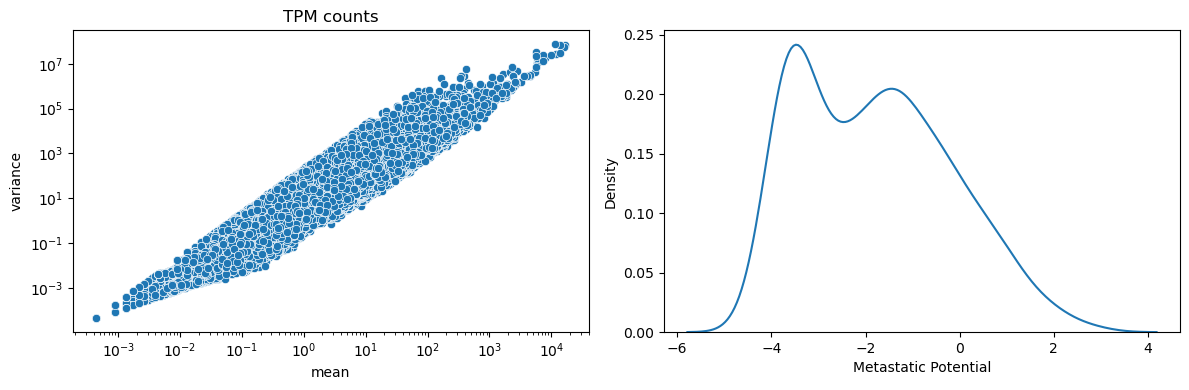

In [ ]:
fig, ax = plt.subplots(ncols = 2, figsize = (12, 4))
ax = ax.flatten()

# subplot 1
i = 0
sns.scatterplot(data = stats_novst, x = 'mean', y = 'variance', ax = ax[i])
ax[i].set_xscale('log')
ax[i].set_yscale('log')
ax[i].set_title('TPM counts')

# subplot 2
# i += 1
# sns.scatterplot(data = stats, x = 'mean', y = 'variance', ax = ax[i])
# ax[i].set_xscale('symlog')
# ax[i].set_yscale('log')
# ax[i].set_title('VST counts')
# ax[i].yaxis.set_major_locator(ticker.FixedLocator([0.01, 0.1, 1, 10]))
# ax[i].yaxis.set_major_formatter(ticker.FormatStrFormatter('%g'))

# # subplot 3
# i+=1
# sns.kdeplot(nexpr.sum().tolist(), ax = ax[i])
# ax[i].set_xlabel('Sample-wise TPM Count Sum')
# # ax[i].set_xscale('log')

# subplot 4
i+=1
sns.kdeplot(data=mp, x='mean', ax = ax[i])
ax[i].set_xlabel('Metastatic Potential')

fig.tight_layout()
;

Filter for lowly expressed genes. We will filter to only includ genes that have expression (TPM >= 0.1) in atleast 5% of all retained samples:

Text(0.5, 0, 'Gene TPM')

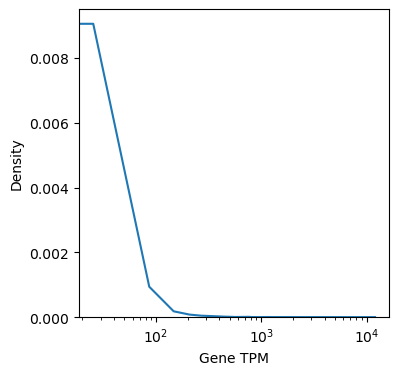

In [ ]:
gene_counts = nexpr.values.flatten()
np.random.seed(seed)
gene_counts_sub = np.random.choice(gene_counts, int(1e4))

fig, ax = plt.subplots(figsize = (4,4))
sns.kdeplot(gene_counts_sub, ax = ax)
ax.set_xscale('log')
ax.set_xlabel('Gene TPM')

In [ ]:
n_genes_og = nexpr.shape[0]
tpm_thresh = 0.1
sample_thresh = int(228/20)
nexpr = nexpr[(nexpr >= tpm_thresh).sum(axis=1) >= sample_thresh]
print('The TPM filter reduces the total number of genes from {} to {}'.format(n_genes_og, nexpr.shape[0]))

The TPM filter reduces the total number of genes from 57711 to 43270


Next, let's map unnamed genes (or drop if cannot map):

In [ ]:
if not os.path.isfile(os.path.join(data_path, 'interim', 'gene_map.csv')):
    mg = mygene.MyGeneInfo()

    ensembl_ids = [i for i in nexpr.index if i.startswith('ENSG')]
    gene_symbols = mg.querymany(ensembl_ids, scopes='ensembl.gene', fields='symbol', species='human')
    gene_map = {gs['query']: gs['symbol'] if 'symbol' in gs else '' for gs in gene_symbols}

    # drop many to one mappings -- only uninfiromative genes anyways
    id_counts = dict(zip(ensembl_ids, [0]*len(ensembl_ids)))
    for gs in gene_symbols:
        id_counts[gs['query']] += 1
    one_to_many = [k for k,v in id_counts.items() if v > 1]
    for k in one_to_many:
        gene_map[k] = ''
    gene_map = pd.DataFrame(data = {'ENSG': gene_map.keys(), 'Gene Symbol': gene_map.values()})
    gene_map.to_csv(os.path.join(data_path, 'interim', 'gene_map.csv'))
else:
    gene_map = pd.read_csv(os.path.join(data_path, 'interim', 'gene_map.csv'), index_col = 0)

n_unmapped = gene_map.shape[0]
gene_map = gene_map[(gene_map['Gene Symbol'] != '') & (gene_map['Gene Symbol'].notna())]
print('Of the {} unmapped genes, we successfully map {}'.format(n_unmapped, gene_map.shape[0]))

# map or drop unmapped
gene_map = dict(zip(gene_map.ENSG, gene_map['Gene Symbol']))
nexpr.index = [gene_map[g] if g in gene_map else g for g in nexpr.index]
ensembl_ids = [i for i in nexpr.index if i.startswith('ENSG')]
nexpr.drop(index = ensembl_ids, inplace = True)
print('The number of genes after excluding unmapped ones is {}'.format(nexpr.shape[0]))

Of the 13022 unmapped genes, we successfully map 2454
The number of genes after excluding unmapped ones is 32702


Let's aggregate duplicated genes by the sum of their values:

In [ ]:
nexpr = nexpr.groupby(nexpr.index).sum()
print('The aggregated number of genes is {}'.format(nexpr.shape[0]))

The aggregated number of genes is 32144


Next, let's exclude non-coding genes. Genes were downloaded from [HGNC](https://www.genenames.org/download/statistics-and-files/) on 12/09/24.

In [ ]:
protein_coding = pd.read_csv(os.path.join(data_path, 'raw', 'protein-coding_gene.txt'), 
                            sep = '\t', low_memory = False).symbol.unique()
nexpr = nexpr[nexpr.index.isin(protein_coding)]
print('There are {} protein coding genes in the final expression matrix'.format(nexpr.shape[0]))

There are 17879 protein coding genes in the final expression matrix


Log-transform and normalize the data. 

Z-scoring has shown good performance for RF and ML ([1](https://doi.org/10.1186/s12859-020-3427-8) and [2](https://doi.org/10.1186/s12967-021-02936-w)). However, to maintain variance across samples, we instead center tha data without normalizing to the standard deviation. 

In [ ]:
nexpr = np.log(nexpr + 1)

Let's select for the top 3000 features that are representative of the variance in the dataset using the coefficient of variation. We do this prior to centering the data. 

In [ ]:
if hvg_selection:
    n_hvgs = 3000
    cov = nexpr.std(axis = 1)/nexpr.mean(axis = 1)
    cov_selected = cov.sort_values(ascending = False)[:n_hvgs]
    hvgs = cov_selected.index.tolist()
    nexpr = nexpr.loc[hvgs,:]
    
    fig, ax = plt.subplots(figsize = (5,4))
    sns.histplot(cv, ax = ax)
    ax.vlines(x = cv_selected.min(), ymin = 0, ymax = ax.get_ybound()[1], 
              color = 'red', linestyle = '--')

Center the data:

In [ ]:
nexpr = nexpr.sub(nexpr.mean(axis=1), axis=0)

Save the files:

In [ ]:
hvg_name = '' if not hvg_selection else 'hvg_'
nmp.to_csv(os.path.join(data_path, 'processed', 'metastatic_potential.csv'))
nexpr.to_csv(os.path.join(data_path, 'processed', hvg_name + 'expr.csv'))